# Pyspark Preprocessing for linear Regression

Define libraries

In [93]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,count,when ,mean

from pyspark.ml.feature import StringIndexer , OneHotEncoder


Read input csv file

In [94]:
# Read csv file
spark = SparkSession.builder.appName("PysparkProcessing").config("spark.driver.bindAddress", "10.0.2.15").getOrCreate()

pyspark_df = spark.read.csv("data_preprocessing.csv",header=True,inferSchema=True)

pyspark_df.show()

+-------+----+------+---------+
|Country| Age|Salary|Purchased|
+-------+----+------+---------+
| France|  44| 72000|       No|
|  Spain|  27| 48000|      Yes|
|Germany|  30| 54000|       No|
|  Spain|  38| 61000|       No|
|Germany|  40|  null|      Yes|
| France|  35| 58000|      Yes|
|  Spain|null| 52000|       No|
| France|  48| 79000|      Yes|
|Germany|  50| 83000|       No|
| France|  37| 67000|      Yes|
+-------+----+------+---------+



In [95]:
# Display row and column count
row_count = pyspark_df.count()
column_count = len(pyspark_df.columns)
print(f"DataFrame Shape: ({row_count}, {column_count})")

DataFrame Shape: (10, 4)


In [96]:
# Describe dataframe
pyspark_df.describe().show()

+-------+-------+-----------------+------------------+---------+
|summary|Country|              Age|            Salary|Purchased|
+-------+-------+-----------------+------------------+---------+
|  count|     10|                9|                 9|       10|
|   mean|   null|38.77777777777778| 63777.77777777778|     null|
| stddev|   null|7.693792591722529|12265.579661982732|     null|
|    min| France|               27|             48000|       No|
|    max|  Spain|               50|             83000|      Yes|
+-------+-------+-----------------+------------------+---------+



Checking Null values in dataset

In [97]:
# null count in age column
age_null_count = pyspark_df.filter(col("Age").isNull()).count()

print(f"Age null count:{age_null_count}")

Age null count:1


In [98]:
# null count in age column
salary_null_count = pyspark_df.filter(col("Salary").isNull()).count()

print(f"Salary null count:{salary_null_count}")

Salary null count:1


In [99]:
# finding null values in all the columns of dataframe
pyspark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in pyspark_df.columns]).show()


+-------+---+------+---------+
|Country|Age|Salary|Purchased|
+-------+---+------+---------+
|      0|  1|     1|        0|
+-------+---+------+---------+



In [100]:
# Replacing purchased column values with binary values
pyspark_df = pyspark_df.withColumn('Purchased',when(col('Purchased') == 'Yes',1).otherwise(0))

pyspark_df.show()

+-------+----+------+---------+
|Country| Age|Salary|Purchased|
+-------+----+------+---------+
| France|  44| 72000|        0|
|  Spain|  27| 48000|        1|
|Germany|  30| 54000|        0|
|  Spain|  38| 61000|        0|
|Germany|  40|  null|        1|
| France|  35| 58000|        1|
|  Spain|null| 52000|        0|
| France|  48| 79000|        1|
|Germany|  50| 83000|        0|
| France|  37| 67000|        1|
+-------+----+------+---------+



Creating a cop

In [101]:
gaussian_spark = pyspark_df.toPandas()

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

Generate gaussian distribution on Age and Salary Independent Varaibles in dataset

Age column

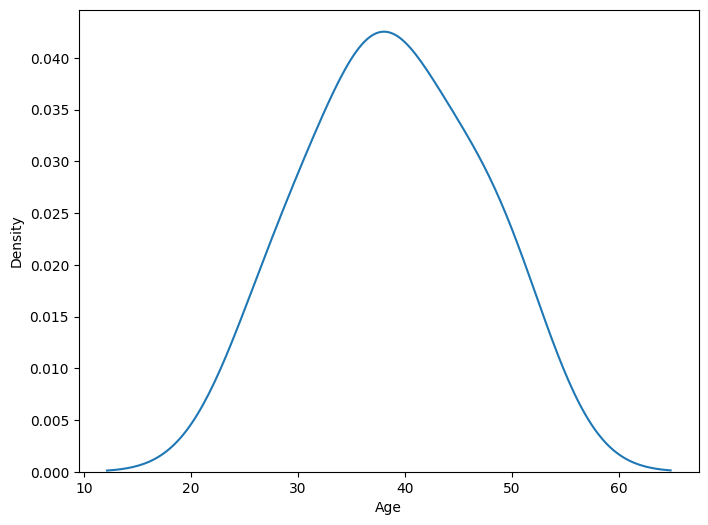

In [103]:
plt.figure(figsize=(8,6))
sns.kdeplot(x=gaussian_spark["Age"])
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

Salary Column

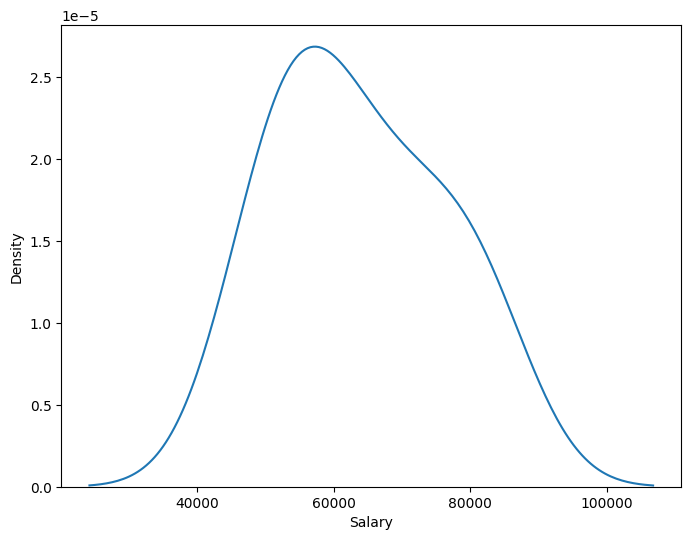

In [104]:
plt.figure(figsize=(8,6))
sns.kdeplot(x=gaussian_spark["Salary"])
plt.xlabel("Salary")
plt.ylabel("Density")
plt.show()

Calculate mean value of columns and replace null value with mean 

In [105]:
age_mean_value = pyspark_df.select(mean(col("Age"))).collect()[0][0]
print(age_mean_value)
pyspark_df = pyspark_df.na.fill(value=age_mean_value,subset="Age")

pyspark_df.show()

38.77777777777778
+-------+---+------+---------+
|Country|Age|Salary|Purchased|
+-------+---+------+---------+
| France| 44| 72000|        0|
|  Spain| 27| 48000|        1|
|Germany| 30| 54000|        0|
|  Spain| 38| 61000|        0|
|Germany| 40|  null|        1|
| France| 35| 58000|        1|
|  Spain| 38| 52000|        0|
| France| 48| 79000|        1|
|Germany| 50| 83000|        0|
| France| 37| 67000|        1|
+-------+---+------+---------+



In [106]:
salary_mean_value = pyspark_df.select(mean(col("Salary"))).collect()[0][0]
print(salary_mean_value)
pyspark_df = pyspark_df.na.fill(value=salary_mean_value,subset="Salary")
pyspark_df.show()

63777.77777777778
+-------+---+------+---------+
|Country|Age|Salary|Purchased|
+-------+---+------+---------+
| France| 44| 72000|        0|
|  Spain| 27| 48000|        1|
|Germany| 30| 54000|        0|
|  Spain| 38| 61000|        0|
|Germany| 40| 63777|        1|
| France| 35| 58000|        1|
|  Spain| 38| 52000|        0|
| France| 48| 79000|        1|
|Germany| 50| 83000|        0|
| France| 37| 67000|        1|
+-------+---+------+---------+



Validate dataset set if any columns with null values are left

In [107]:
# checking again for null values
# finding null values in all the columns of dataframe
pyspark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in pyspark_df.columns]).show()


+-------+---+------+---------+
|Country|Age|Salary|Purchased|
+-------+---+------+---------+
|      0|  0|     0|        0|
+-------+---+------+---------+



# Encoding - One hot encoder

label encoding for category indexing

In [108]:
indexer = StringIndexer(inputCol="Country", outputCol="Country_index")
indexed_fitted = indexer.fit(pyspark_df)
indexed_df = indexed_fitted.transform(pyspark_df)
indexed_df.show()

+-------+---+------+---------+-------------+
|Country|Age|Salary|Purchased|Country_index|
+-------+---+------+---------+-------------+
| France| 44| 72000|        0|          0.0|
|  Spain| 27| 48000|        1|          2.0|
|Germany| 30| 54000|        0|          1.0|
|  Spain| 38| 61000|        0|          2.0|
|Germany| 40| 63777|        1|          1.0|
| France| 35| 58000|        1|          0.0|
|  Spain| 38| 52000|        0|          2.0|
| France| 48| 79000|        1|          0.0|
|Germany| 50| 83000|        0|          1.0|
| France| 37| 67000|        1|          0.0|
+-------+---+------+---------+-------------+



In [109]:
# one hot encoding
encoder = OneHotEncoder(inputCol="Country_index", outputCol="Country_vector",dropLast=False)
encoded_df = encoder.fit(indexed_df).transform(indexed_df)
encoded_df.show()

+-------+---+------+---------+-------------+--------------+
|Country|Age|Salary|Purchased|Country_index|Country_vector|
+-------+---+------+---------+-------------+--------------+
| France| 44| 72000|        0|          0.0| (3,[0],[1.0])|
|  Spain| 27| 48000|        1|          2.0| (3,[2],[1.0])|
|Germany| 30| 54000|        0|          1.0| (3,[1],[1.0])|
|  Spain| 38| 61000|        0|          2.0| (3,[2],[1.0])|
|Germany| 40| 63777|        1|          1.0| (3,[1],[1.0])|
| France| 35| 58000|        1|          0.0| (3,[0],[1.0])|
|  Spain| 38| 52000|        0|          2.0| (3,[2],[1.0])|
| France| 48| 79000|        1|          0.0| (3,[0],[1.0])|
|Germany| 50| 83000|        0|          1.0| (3,[1],[1.0])|
| France| 37| 67000|        1|          0.0| (3,[0],[1.0])|
+-------+---+------+---------+-------------+--------------+



Convert Vector values in columns to array

In [110]:
from pyspark.ml.functions import vector_to_array
df_col_onehot = encoded_df.select('*', vector_to_array('Country_vector').alias('col_onehot'))
df_col_onehot.show()

+-------+---+------+---------+-------------+--------------+---------------+
|Country|Age|Salary|Purchased|Country_index|Country_vector|     col_onehot|
+-------+---+------+---------+-------------+--------------+---------------+
| France| 44| 72000|        0|          0.0| (3,[0],[1.0])|[1.0, 0.0, 0.0]|
|  Spain| 27| 48000|        1|          2.0| (3,[2],[1.0])|[0.0, 0.0, 1.0]|
|Germany| 30| 54000|        0|          1.0| (3,[1],[1.0])|[0.0, 1.0, 0.0]|
|  Spain| 38| 61000|        0|          2.0| (3,[2],[1.0])|[0.0, 0.0, 1.0]|
|Germany| 40| 63777|        1|          1.0| (3,[1],[1.0])|[0.0, 1.0, 0.0]|
| France| 35| 58000|        1|          0.0| (3,[0],[1.0])|[1.0, 0.0, 0.0]|
|  Spain| 38| 52000|        0|          2.0| (3,[2],[1.0])|[0.0, 0.0, 1.0]|
| France| 48| 79000|        1|          0.0| (3,[0],[1.0])|[1.0, 0.0, 0.0]|
|Germany| 50| 83000|        0|          1.0| (3,[1],[1.0])|[0.0, 1.0, 0.0]|
| France| 37| 67000|        1|          0.0| (3,[0],[1.0])|[1.0, 0.0, 0.0]|
+-------+---

In [111]:
import pyspark.sql.functions as F

In [112]:
# expanding array to seperate category columns
num_categories = len(df_col_onehot.first()['col_onehot'])   
cols_expanded = [(F.col('col_onehot')[i].alias(f'{indexed_fitted.labels[i]}')) for i in range(num_categories)]
df_cols_onehot = df_col_onehot.select('Age', 'Salary',*cols_expanded,'Purchased')
df_cols_onehot.show()

+---+------+------+-------+-----+---------+
|Age|Salary|France|Germany|Spain|Purchased|
+---+------+------+-------+-----+---------+
| 44| 72000|   1.0|    0.0|  0.0|        0|
| 27| 48000|   0.0|    0.0|  1.0|        1|
| 30| 54000|   0.0|    1.0|  0.0|        0|
| 38| 61000|   0.0|    0.0|  1.0|        0|
| 40| 63777|   0.0|    1.0|  0.0|        1|
| 35| 58000|   1.0|    0.0|  0.0|        1|
| 38| 52000|   0.0|    0.0|  1.0|        0|
| 48| 79000|   1.0|    0.0|  0.0|        1|
| 50| 83000|   0.0|    1.0|  0.0|        0|
| 37| 67000|   1.0|    0.0|  0.0|        1|
+---+------+------+-------+-----+---------+



# Scaling Independent variables

In [113]:
# getting dataframe for manual Scaling 
df_cols_onehot_manual = df_cols_onehot

Manual scaling using user defined formula

In [114]:
# min and max values of feature column
age_min_value = df_cols_onehot_manual.select(F.min("Age")).collect()[0][0]
age_max_value = df_cols_onehot_manual.select(F.max("Age")).collect()[0][0]

salary_min_value = df_cols_onehot_manual.select(F.min("Salary")).collect()[0][0]
salary_max_value = df_cols_onehot_manual.select(F.max("Salary")).collect()[0][0]

In [115]:
# Defining a function to implement min max scaler formula
def min_max_scaling(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)


In [116]:
df_cols_onehot_manual = df_cols_onehot_manual.withColumn("Age", F.udf(min_max_scaling)(F.col("Age"), F.lit(age_min_value), F.lit(age_max_value)))
df_cols_onehot_manual = df_cols_onehot_manual.withColumn("Salary", F.udf(min_max_scaling)(F.col("Salary"), F.lit(salary_min_value), F.lit(salary_max_value)))

In [117]:
df_cols_onehot_manual.show()

+-------------------+-------------------+------+-------+-----+---------+
|                Age|             Salary|France|Germany|Spain|Purchased|
+-------------------+-------------------+------+-------+-----+---------+
| 0.7391304347826086| 0.6857142857142857|   1.0|    0.0|  0.0|        0|
|                0.0|                0.0|   0.0|    0.0|  1.0|        1|
|0.13043478260869565|0.17142857142857143|   0.0|    1.0|  0.0|        0|
| 0.4782608695652174|0.37142857142857144|   0.0|    0.0|  1.0|        0|
| 0.5652173913043478|0.45077142857142855|   0.0|    1.0|  0.0|        1|
|0.34782608695652173| 0.2857142857142857|   1.0|    0.0|  0.0|        1|
| 0.4782608695652174|0.11428571428571428|   0.0|    0.0|  1.0|        0|
| 0.9130434782608695| 0.8857142857142857|   1.0|    0.0|  0.0|        1|
|                1.0|                1.0|   0.0|    1.0|  0.0|        0|
|0.43478260869565216| 0.5428571428571428|   1.0|    0.0|  0.0|        1|
+-------------------+-------------------+------+---

Min Max Scaling using  Min max scaler library

In [118]:
# min max scaler 
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler , VectorAssembler
columns_to_scale = ["Age", "Salary"]

assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(df_cols_onehot)
scaledData = scalerModel.transform(df_cols_onehot)

scaledData.show()

+---+------+------+-------+-----+---------+-------+----------+--------------------+--------------------+
|Age|Salary|France|Germany|Spain|Purchased|Age_vec|Salary_vec|          Age_scaled|       Salary_scaled|
+---+------+------+-------+-----+---------+-------+----------+--------------------+--------------------+
| 44| 72000|   1.0|    0.0|  0.0|        0| [44.0]| [72000.0]|[0.7391304347826086]|[0.6857142857142857]|
| 27| 48000|   0.0|    0.0|  1.0|        1| [27.0]| [48000.0]|               [0.0]|               [0.0]|
| 30| 54000|   0.0|    1.0|  0.0|        0| [30.0]| [54000.0]|[0.13043478260869...|[0.17142857142857...|
| 38| 61000|   0.0|    0.0|  1.0|        0| [38.0]| [61000.0]|[0.4782608695652174]|[0.37142857142857...|
| 40| 63777|   0.0|    1.0|  0.0|        1| [40.0]| [63777.0]|[0.5652173913043478]|[0.45077142857142...|
| 35| 58000|   1.0|    0.0|  0.0|        1| [35.0]| [58000.0]|[0.34782608695652...|[0.2857142857142857]|
| 38| 52000|   0.0|    0.0|  1.0|        0| [38.0]| [52

In [119]:
from pyspark.sql.functions import round

Replacing age and salry column with age_scaled and salary_scaled data

In [120]:
scaledData = scaledData.withColumn("Age", F.col("Age_scaled"))
scaledData = scaledData.withColumn("Salary", F.col("Salary_scaled"))

# Drop the intermediate columns if needed
scaledData = scaledData.drop("Age_scaled", "Salary_scaled",'Age_vec','Salary_vec')
scaledData.show()


+--------------------+--------------------+------+-------+-----+---------+
|                 Age|              Salary|France|Germany|Spain|Purchased|
+--------------------+--------------------+------+-------+-----+---------+
|[0.7391304347826086]|[0.6857142857142857]|   1.0|    0.0|  0.0|        0|
|               [0.0]|               [0.0]|   0.0|    0.0|  1.0|        1|
|[0.13043478260869...|[0.17142857142857...|   0.0|    1.0|  0.0|        0|
|[0.4782608695652174]|[0.37142857142857...|   0.0|    0.0|  1.0|        0|
|[0.5652173913043478]|[0.45077142857142...|   0.0|    1.0|  0.0|        1|
|[0.34782608695652...|[0.2857142857142857]|   1.0|    0.0|  0.0|        1|
|[0.4782608695652174]|[0.11428571428571...|   0.0|    0.0|  1.0|        0|
|[0.9130434782608695]|[0.8857142857142857]|   1.0|    0.0|  0.0|        1|
|               [1.0]|               [1.0]|   0.0|    1.0|  0.0|        0|
|[0.43478260869565...|[0.5428571428571428]|   1.0|    0.0|  0.0|        1|
+--------------------+---

# Training model


splitting data into train and test data

In [ ]:
train_ratio = 0.7
test_ratio = 1 - train_ratio

# Split the data into train and test DataFrames
train_data, test_data = scaledData.randomSplit([train_ratio, test_ratio])

train_data.show()

+--------------------+--------------------+------+-------+-----+---------+
|                 Age|              Salary|France|Germany|Spain|Purchased|
+--------------------+--------------------+------+-------+-----+---------+
|               [0.0]|               [0.0]|   0.0|    0.0|  1.0|        1|
|[0.13043478260869...|[0.17142857142857...|   0.0|    1.0|  0.0|        0|
|[0.4782608695652174]|[0.37142857142857...|   0.0|    0.0|  1.0|        0|
|[0.5652173913043478]|[0.45077142857142...|   0.0|    1.0|  0.0|        1|
|[0.7391304347826086]|[0.6857142857142857]|   1.0|    0.0|  0.0|        0|
|[0.9130434782608695]|[0.8857142857142857]|   1.0|    0.0|  0.0|        1|
|               [1.0]|               [1.0]|   0.0|    1.0|  0.0|        0|
+--------------------+--------------------+------+-------+-----+---------+



Splitting train and test data into x=independent varaibles and y=target variables 

In [ ]:
features = scaledData.columns
target = 'Purchased'
features.remove("Purchased")
x_train = train_data.select(features)
y_train = train_data.select(target)

x_test = test_data.select(features)
y_test = test_data.select(target)

In [ ]:
x_train.show()


+--------------------+--------------------+------+-------+-----+
|                 Age|              Salary|France|Germany|Spain|
+--------------------+--------------------+------+-------+-----+
|               [0.0]|               [0.0]|   0.0|    0.0|  1.0|
|[0.13043478260869...|[0.17142857142857...|   0.0|    1.0|  0.0|
|[0.4782608695652174]|[0.37142857142857...|   0.0|    0.0|  1.0|
|[0.5652173913043478]|[0.45077142857142...|   0.0|    1.0|  0.0|
|[0.7391304347826086]|[0.6857142857142857]|   1.0|    0.0|  0.0|
|[0.9130434782608695]|[0.8857142857142857]|   1.0|    0.0|  0.0|
|               [1.0]|               [1.0]|   0.0|    1.0|  0.0|
+--------------------+--------------------+------+-------+-----+



In [ ]:
y_train.show()

+---------+
|Purchased|
+---------+
|        1|
|        0|
|        0|
|        1|
|        0|
|        1|
|        0|
+---------+



Stop the spark session 

In [ ]:
spark.stop()